# 課題8 線形回帰

配点
- Q1 1
- Q2 1
- Q3 5
- Q4 3


In [2]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2021S/master/ex8/iris.csv

--2021-12-06 18:47:08--  https://raw.githubusercontent.com/UTDataMining/2021S/master/ex8/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3716 (3.6K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.63K  --.-KB/s    in 0s      

2021-12-06 18:47:08 (47.5 MB/s) - ‘iris.csv’ saved [3716/3716]



## Q1 特徴間の相関係数

irisデータセットの特徴量`petal_length`と`petal_width`の関係を散布図で可視化すると以下のように2つの特徴量間に関係があることがわかります。

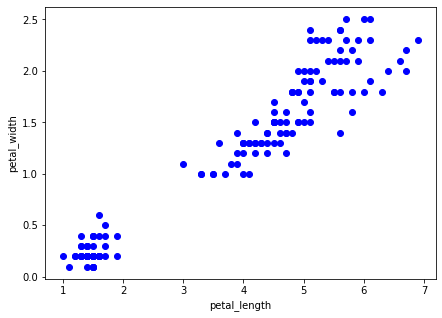

In [4]:
iris = pd.read_csv('iris.csv')

plt.figure(figsize=(7,5))
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.scatter(iris['petal_length'], iris['petal_width'],
            c='blue');

irisデータセットの特徴量`petal_length`と`petal_width`のデータを`NumPy`の配列として受け取って、それらの相関係数を返す以下の関数`petal_corr()`を完成させてください。

In [37]:
def petal_corr(x, y):
  x = np.ravel(x)
  y = np.ravel(y)
  return np.dot(x - x.mean(), y - y.mean()) / (np.sqrt(np.sum((x - x.mean()) ** 2)) * np.sqrt(np.sum((y - y.mean()) ** 2)))

関数`petal_corr()`が完成したら以下のセルを実行して動作を確認してください。以下では`pandas`シリーズオブジェクトの`values`属性を用いて特徴量データを`NumPy`の配列にして関数`petal_corr()`の引数に渡しています。相関係数は$\simeq0.96$となります。

In [38]:
X = iris[['petal_length']].values # 入力X
y = iris[['petal_width']].values # 出力y

petal_corr(X, y)

0.9627570970509665

## Q2 特徴量の標準化

以下では、線形回帰により特徴量`petal_length`から特徴量`petal_width`を予測するような仮説関数のパラメータを学習することを考えます。

まず準備として、特徴量`petal_length`を入力$X$、特徴量`petal_length`を出力$y$としてそれぞれを標準化します。

`NumPy`の任意の行数、列数の2次元配列を受け取り、各要素の値をその列の平均値と標準偏差を用いて標準化した配列を返す`normalizer()`関数を完成させてください。

In [42]:
def normalizer(mat):
  return (mat - np.mean(mat, axis=0)) / np.std(mat, axis=0)

`normalizer()`関数が完成したら、以下のセルを実行して、`X`の列（ここでは先頭列を確認）が平均0、標準偏差1に標準化されることを確認してください。

In [43]:
print(np.round(np.mean(normalizer(X), axis=0))[0])
print(np.round(np.std(normalizer(X), axis=0))[0])

0.0
1.0


次に、入力の各データにバイアス項($x_0=1$)を追加するため、入力の先頭列に1を要素とする列ベクトルを挿入します。これにより、入力,　出力はデータ数を$m$として以下のような行列（$m \times 2$) とベクトル($m \times 1$)になります。

$
  X = \left(
    \begin{array}{cc}
      1 &   x^{(1)} \\
      1 &   x^{(2)}  \\
      ... & ... \\
      1 &  x^{(m)}
    \end{array}
  \right)
$

$x^{(i)}$は標準化された特徴量petal_length。

$
  y = \left(
    \begin{array}{c}
       y^{(1)}  \\
      ...\\
        y^{(m)}  \\
    \end{array}
  \right)
$

$y^{(i)}$は標準化された特徴量petal_width。

In [44]:
X_norm = normalizer(X) # 入力の標準化
y_norm = normalizer(y) # 出力の標準化

X_norm = np.hstack([np.ones((X.shape[0],1)), X_norm]) # バイアス項の追加

print(X_norm[:10,:]) # 先頭10行のデータ
print(y_norm[:10]) # 先頭10行のデータ

[[ 1.         -1.3412724 ]
 [ 1.         -1.3412724 ]
 [ 1.         -1.39813811]
 [ 1.         -1.2844067 ]
 [ 1.         -1.3412724 ]
 [ 1.         -1.17067529]
 [ 1.         -1.3412724 ]
 [ 1.         -1.2844067 ]
 [ 1.         -1.3412724 ]
 [ 1.         -1.2844067 ]]
[[-1.31297673]
 [-1.31297673]
 [-1.31297673]
 [-1.31297673]
 [-1.31297673]
 [-1.05003079]
 [-1.18150376]
 [-1.31297673]
 [-1.31297673]
 [-1.4444497 ]]


## Q3 最急降下法

以下では、最急降下法により、訓練データセットを元に入力から出力を予測する仮説関数のパラメータを学習する`graddes`関数を実装します。

`graddes`関数では第1引数に入力のデータ行列（データ数($m$)$\times$(特徴量数+バイアス)($n$))、第2引数に入力の各データに対する出力（正解）のベクトル（$m\times1$）、第3引数に学習率、第4引数に学習の繰り返し（各繰り返しをエポックと呼ぶ）の回数を受け取ります。

これらの引数を元に、`graddes`関数ではパラメータの学習を行い、以下を返します
- エポックごとのコスト関数の値を要素とするリスト
- 最終的なパラメータの値を要素とする配列（$n\times1$）を返します。



パラメータを$\theta=(\theta_0, \theta_1, ..., \theta_{n-1})^T$

仮説関数を$h(x)=\theta_0+\theta_1x_1+\theta_2x_2+....+\theta_{n-1}x_{n-1}$

入力を$
  X = \left(
    \begin{array}{cccc}
      x_0^{(1)} &   x_1^{(1)} & ... &   x_{n-1}^{(1)}  \\
      ... & ...& ...&...\\
      x_0^{(m)} &  x_1^{(m)} & ... &   x_{n-1}^{(m)}  \\
    \end{array}
  \right)
$ 

$X$において$x_0^{(i)}=1$

出力を$y=(y^{(1)}, y^{(2)}, ..., y^{(m)})^T$

とすると、最急降下法ではコスト関数を

$J(\theta)=\frac{1}{2m}\Sigma_{i=1}^m (h(x^{(i)})-y^{(i)})^2$

として、入力$X$の各特徴量$x_j$に対するパラメータ$\theta_j$を以下の様に更新していきます。

$\theta_j:= \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j} =  \theta_j - \frac{\alpha}{m} \Sigma_{i=1}^m ((h(x^{(i)})-y^{(i)})x^{(i)}_j)$

パラメータ全体を以下のように一度に更新することもできます。

$\theta := \theta - \frac{\alpha}{m}X^T(X\theta-y)$

入力が1特徴量（変数）の時は、バイアス項に対するパラメータを$\theta_0$、入力変数に対するパラメータを$\theta_1$としてパラメータは以下の様に更新されます。

$\theta_0 := \theta_0 - \alpha  \Sigma_{i=1}^m (h(x^{(i)})-y^{(i)})/m$ 

$\theta_1 := \theta_1 - \alpha  \Sigma_{i=1}^m ((h(x^{(i)})-y^{(i)})x^{(i)})/m$

具体的に、`graddes`関数では以下の手順によりパラメータの学習を行います。

- 引数`n_iter`で指定されたエポックの回数だけ以下を繰り返す    

     - すべてのm個のデータについて以下を求める
        
        - 入力データ$x^{(i)}$について仮説関数$h(x^{(i)})$の値を求める
        
        - 出力$y^{(i)}$との誤差$h(x^{(i)})-y^{(i)}$の値を求める
    
     - すべてのm個のデータの誤差を用いてコスト関数$J(\theta)$の値を求め、各エポックのコスト関数の値を要素とするリスト`costs`に追加
 
     - すべてのm個のデータの誤差を用いて各パラメータ$\theta_j(j=0,..,n-1)$を更新し、パラメータの値を要素とする配列`w`を更新
          - `w[0,0]`$:=$($x_0$に対するパラメータ$\theta_0$), 
          - ...,
          - `w[n-1,0]`$:=$($x_{n-1}$に対するパラメータ$\theta_{n-1}$)
          
 すべての繰り返しが終了したらリスト`costs`と配列`w`を返す。
 
 上記に従って、`graddes`関数を完成させてください。

In [45]:
def graddes(X, y, alpha, n_iter):  
  m = X.shape[0] # データ数
  n = X.shape[1] # 次元（特徴量+バイアス）数
  
  costs = [] # エポックごとのコスト関数の値を入れるリスト
  w = np.zeros((n,1)) #  各特徴量に対するパラメータ（重み）の初期化
  
  for i in range(n_iter):
    costs.append(np.sum((np.dot(X, w) - y) ** 2) / (2 * m))
    w -= (alpha / m) * np.dot(X.T, np.dot(X, w) - y)

  return costs, w

`graddes`関数が完成したら以下のセルを実行して動作を確認してください。上記のirisデータセットの特徴量`petal_length`を入力、特徴量`petal_length`を出力とした訓練データセットを与え、学習率を0.05、学習のエポック数を20とした時の最終的なコスト関数の値は$\simeq 0.102$となります。

In [46]:
n_iter=20
alpha=0.05
costs, w = graddes(X_norm, y_norm, alpha, n_iter)
print(costs[-1]) # 100エポックでのコスト関数の値
print(w) # 推定されたパラメータ

0.10254277979140763
[[-1.72861725e-16]
 [ 6.17622231e-01]]


以下では、パラメータ推定の過程の各エポックとコスト関数の値の関係を示しています。パラメータの学習が進むにつれてコスト関数の値が減少していくことがわかります。

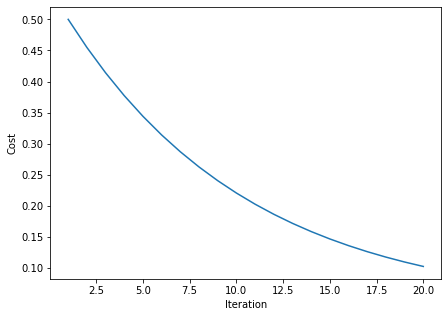

In [47]:
plt.figure(figsize=(7,5))
plt.ylabel('Cost')
plt.xlabel('Iteration');
plt.plot(range(1,n_iter+1),costs);

学習率0.05、学習のエポック数20として学習されたパラメータ$\theta_0, \theta_1$を用いて特徴量`petal_length`を入力$x$、特徴量`petal_length`を出力$y$とした時の直線$y=\theta_0+\theta_1x$は以下のようになります。

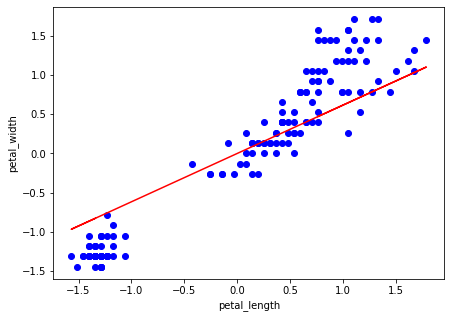

In [48]:
# 回帰直線のプロット
def lineplot(X,y,w):
    plt.figure(figsize=(7,5))
    plt.xlabel('petal_length')
    plt.ylabel('petal_width')
    plt.scatter(X[:,1],y[:,0],c='blue')
    plt.plot(X[:,1], np.dot(X,w)[:,0], color='red');

lineplot(X_norm, y_norm, w)

また、この時のコスト関数$J(\theta)$とパラメータ$\theta_0, \theta_1$は以下のようになります。

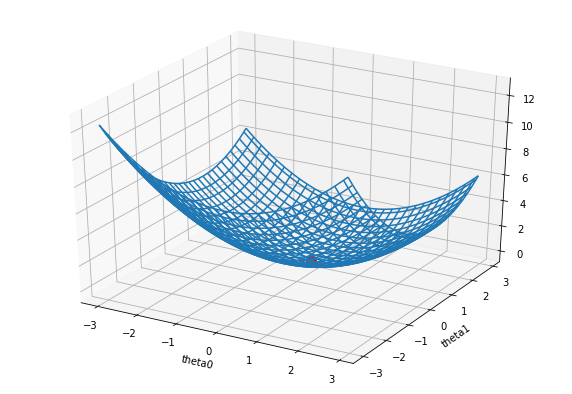

In [51]:
from mpl_toolkits.mplot3d import Axes3D

# コスト関数のプロット
def costplot(X, y, w, cost):
    w0, w1 = np.meshgrid(np.arange(-3.0, 3.0, 0.1), np.arange(-3.0, 3.0, 0.1))
    J=np.zeros(w0.shape)
    for i in range(w0.shape[0]):
        for j in range(w0.shape[1]):
            J[i,j] = np.sum((np.dot(X, np.array([[w0[i,j]],[w1[i,j]]]))-y)**2)/(2*X.shape[0])
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("theta0")
    ax.set_ylabel("theta1")
    ax.scatter(w[0,0], w[1,0], cost, s=100, c='red')
    ax.plot_wireframe(w0, w1, J);

costplot(X_norm, y_norm, w, costs[-1])

学習率$\alpha$やエポック数を変更して、その時の最終的なパラメータ、コスト関数の値をそれぞれ観察してください。

コスト関数の値が十分に収束した時の学習率、エポック数で学習されたパラメータを用いて回帰直線を可視化してください。

0.10254277979140763
[[-1.72861725e-16]
 [ 6.17622231e-01]]


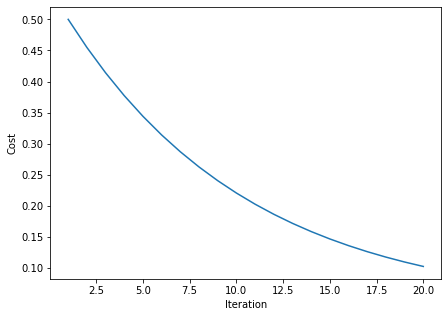

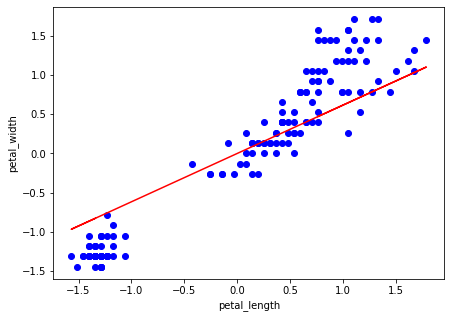

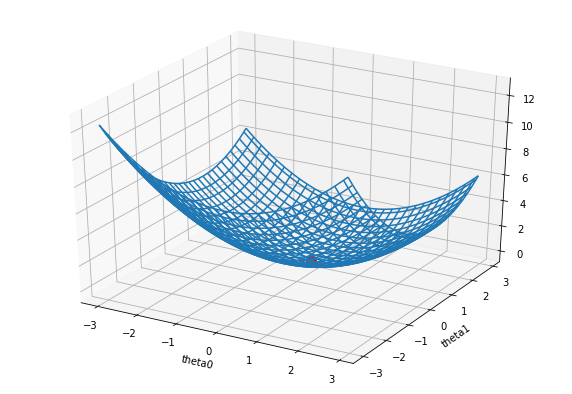

In [56]:
n_iter = 20 #エポック数
alpha = 0.05 #学習率
costs, w = graddes(X_norm, y_norm, alpha, n_iter)
print(costs[-1]) # コスト関数の値
print(w) # 推定されたパラメータ

# エポック数 vs. コスト関数
plt.figure(figsize=(7,5))
plt.ylabel('Cost')
plt.xlabel('Iteration');
plt.plot(range(1,n_iter+1),costs);

# 回帰直線
lineplot(X_norm, y_norm, w)

# コスト関数
costplot(X_norm, y_norm, w, costs[-1] )

## Q4 正規方程式
線形回帰のパラメータは訓練データセットの入力$X$と出力$y$に対して以下の正規方程式を解くことで解析的に求めることができます。（ただし、$X^TX$が正則（フルランク）であること。）

$\theta = (X^TX)^{-1}X^Ty$

ここで、行列$A$の転置$A^T$、逆行列$A^{-1}$は`NumPy`を用いてそれぞれ以下の様に計算できます。

転置$A^T$
```Python
A.T
```

逆行列$A^{-1}$
```Python
np.linalg.inv(A)
```

正規方程式を用いて、訓練データセットを元に入力から出力を予測する仮説関数のパラメータを求める`normal_equation`関数を実装してください。`normal_equation`関数では第1引数に入力のデータ行列（データ数($m$)$\times$次元数($n$))、第2引数に入力の各データに対する出力（正解）のベクトル（$m\times1$）を受け取り、パラメータ$\theta$の値を要素とする配列（$n\times1$）（Q3のパラメータの配列`w`と同様の形式）を返します。

In [66]:
def normal_equation(X, y):
  return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

`normal_equation`関数が完成したら以下のセルを実行して動作を確認してください。先の最急降下法で求めたパラメータの推定値が正規方程式に基づくパラメータの解析解とよく近似していることがわかります。

[[-3.19189120e-16]
 [ 9.62757097e-01]]


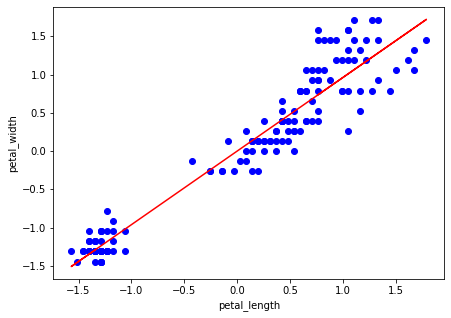

In [67]:
w=normal_equation(X_norm, y_norm)
print(w)

lineplot(X_norm, y_norm, w)

## コードのテスト
以下の実行ボタンを押してから、設問ごとにCheck関数でコードのテストをしてください。

In [59]:
## コードのテストの前にこのセルを実行してください
!pip install prog_edu_assistant_tools
import re
import sys
import jinja2
from IPython.core import display
from google.colab import _message as google_message
from prog_edu_assistant_tools.magics import report, autotest, CaptureOutput
from prog_edu_assistant_tools.check import Check

## Q1

In [60]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q1')

## Q2

In [61]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q2')

## Q3

In [62]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q3')

## Q4

In [68]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q4')